In [75]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

sys.path.append("..")

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd
import Models.process as process

import scipy.optimize as opt

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8)
        
    params[0] = .001 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    params[5] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    params[6] = 13 + 125*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .5] #A(0)
    paramConstraints[1] = [ 0.000000001, .25] #I(0)

    paramConstraints[2] = [0.00001, parameters[5]] #gamma0, has to be less than ceiling infection rate
    paramConstraints[3] = [0.00001, .9] #gamma1
    
    paramConstraints[4] = [0.00001, .9] #nu

    paramConstraints[5] = [.1, 100] #beta0, beta ceiling
    paramConstraints[6] = [.1, 100000] #beta1, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:8]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

def getStablePoint(params, consts):
    #I stable point = (b0/gamm0 - 1)^(1/b2) / b1
    #A stable point = nu/gamma1 * (b0/gamm0 - 1)^(1/b2) / b1
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    beta = params[5:]
    
    return (beta[0]/gamma0 - 1)**(1/beta[2]) / beta[1]

def getIndex(A, item):
    index = 0
    while(index < len(A) and A[index] != item):
        index = index + 1
    
    if(index == len(A)):
        return -1 #doesn't exists
    return index #found


##########################################################################################

def getIndex(A, item):
    index = 0
    while(index < len(A) and A[index] != item):
        index = index + 1
    
    if(index == len(A)):
        return -1 #doesn't exists
    return index #found

import csv
import platform
import os.path
def getCountryDates(countryName, filePathOver=""):
    fileName = "../../Data/Country Policy Data/" #mac file address
    if(filePathOver!=""): #override was set
        fileName = filePathOver
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")
    fileName = fileName+countryName + ".csv"
    
    if(not os.path.exists(fileName)):
        return []
    
    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity
    
    return data[:,0].transpose() #just the dates

####################################################################



21.290788627826473
18.981811949074835
19.430956637247352
7.0896848847298255


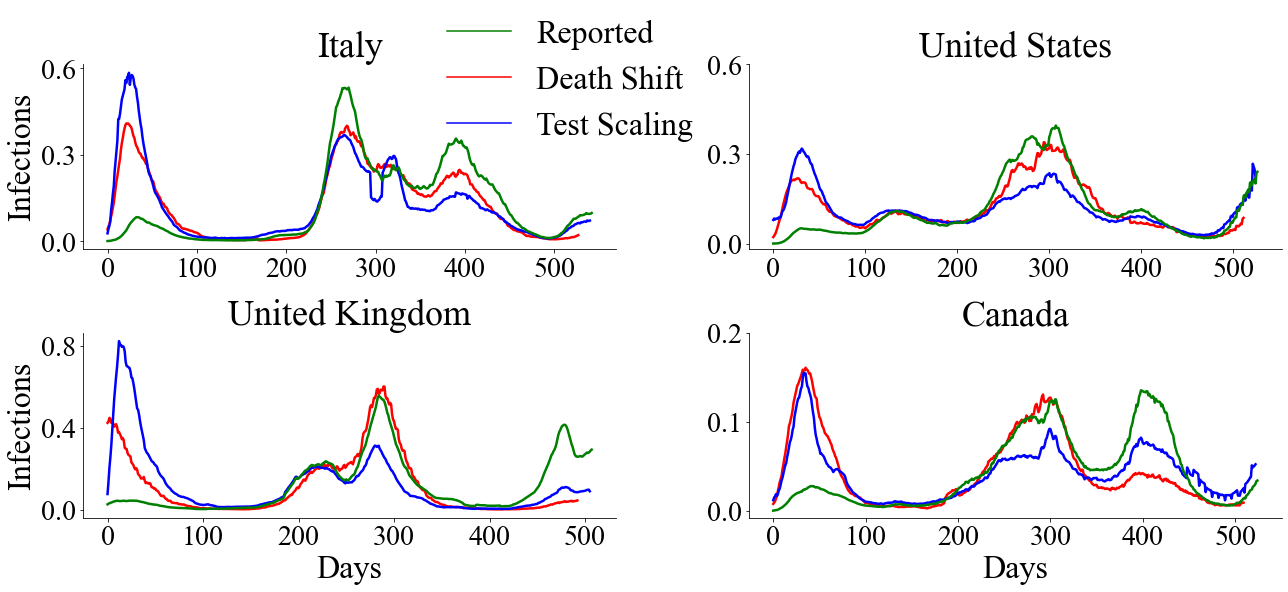

In [64]:
import matplotlib.lines
plt.rcParams['font.family'] = "Times New Roman"

fig, ax = plt.subplots(2,2, figsize=(18,8))

def getIScaleData(countryName):
    dates, I, R, D, V = owid.LoadCountryNormalDeaths(countryName, shiftAmount=15) #deaths
    dates2, I2, R2, D2, V2 = owid.LoadCountryNormal(countryName) #tests
    dates3, [I3, D3, pop] = owid.LoadCountry(countryName, selectColumns=[4, 7, 46]) #normal
    
    I = I + R + D
    scale = 2500*(D3[-1]/pop[0])/I[-1]
    I = scale*I
    R = scale*R
    D = scale*D
    I = I - R - D
    
    I2 = I2 + R2 + D2
    scale = 2500*(D3[-1]/pop[0])/I2[-1]
    print(scale)
    I2 = scale*I2
    R2 = scale*R2
    D2 = scale*D2
    I2 = I2 - R2 - D2
    
    R3 = process.getRecov(I3, D3)
    scale =  2500*(D3[-1]/pop[0])/I3[-1]
    I3 = scale*I3
    R3 = scale*R3
    D3 = scale*D3
    I3 = I3 - D3 - R3

    startDate = dates[0]
    if(dates2[0] > dates[0]):
        startDate = dates2[0]

    I = I[getIndex(dates, startDate):]
    I2 = I2[getIndex(dates2,startDate):]
    I3 = I3[getIndex(dates3,startDate):]

    dates = dates[getIndex(dates, startDate):]
    dates2 = dates2[getIndex(dates2,startDate):]
    dates3 = dates3[getIndex(dates3,startDate):]
    
    return I3, I, I2 #reported, death method, test method

I1, I2, I3 = getIScaleData("Italy")
ax[0][0].plot(I2, color="red", linewidth=2.5)
ax[0][0].plot(I3, color="blue", linewidth=2.5)
ax[0][0].plot(I1, color="green", linewidth=2.5)
ax[0][0].set_title("Italy", fontsize=36)

I1, I2, I3 = getIScaleData("United States")
ax[0][1].plot(I2, color="red", linewidth=2.5)
ax[0][1].plot(I3, color="blue", linewidth=2.5)
ax[0][1].plot(I1, color="green", linewidth=2.5)
ax[0][1].set_title("United States", fontsize=36)

I1, I2, I3 = getIScaleData("United Kingdom")
ax[1][0].plot(I2, color="red", linewidth=2.5)
ax[1][0].plot(I3, color="blue", linewidth=2.5)
ax[1][0].plot(I1, color="green", linewidth=2.5)
ax[1][0].set_title("United Kingdom", fontsize=36)

I1, I2, I3 = getIScaleData("Canada")
ax[1][1].plot(I2, color="red", linewidth=2.5)
ax[1][1].plot(I3, color="blue", linewidth=2.5)
ax[1][1].plot(I1, color="green", linewidth=2.5)
ax[1][1].set_title("Canada", fontsize=36)

line1 = matplotlib.lines.Line2D([0.5,1], [0,0], color="green")
line2 = matplotlib.lines.Line2D([0,1], [0,0], color="red")
line3 = matplotlib.lines.Line2D([0,1], [0,0], color="blue")

#fig.suptitle("True Infection Estimations of Different Methods", fontsize=30)
fig.legend([line1, line2, line3], ["Reported", "Death Shift", "Test Scaling"], 
           
           fontsize=32, loc="upper right", bbox_to_anchor=(.56,1.05), frameon=False)

ax[1][0].set_xlabel("Days", fontsize=32)
ax[1][1].set_xlabel("Days", fontsize=32)

ax[0][0].set_ylabel("Infections", fontsize=32)
ax[1][0].set_ylabel("Infections", fontsize=32)

#print(dates[0], dates2[0], dates3[0])

consts = [len(I1), I1[0], max(I1), 0]


from matplotlib.ticker import MaxNLocator

for i in range(0,2):
    for j in range(0,2):
        #ax[i][j].yaxis.set_major_locator(MaxNLocator(3)) 
        ax[i][j].tick_params(axis='x', labelsize=28)
        ax[i][j].tick_params(axis='y', labelsize=28)
        
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['right'].set_visible(False)
        
        #ax[i][j].grid()

ax[0][0].set_yticks([0, .3, .6])
ax[0][1].set_yticks([0, .3, .6])
ax[1][0].set_yticks([0, .4, .8])
ax[1][1].set_yticks([0, .1, .2])

plt.tight_layout()

fig.subplots_adjust(hspace=.45, wspace = .25)


plt.savefig("../../Feedback Conference Paper/DifferentMethods.eps", bbox_inches = 'tight')

In [2]:
#testing all fonts
#import matplotlib.font_manager
##flist = matplotlib.font_manager.get_fontconfig_fonts()
#names = [matplotlib.font_manager.FontProperties(fname=fname).get_name() for fname in flist]
#print(names)

In [56]:
def diffSameSize(A):
    B = np.zeros(len(A))
    B[0] = 0 #assume previous day was same as start day
    B[1:] = A[1:] - A[0:-1]
    
    return B

import csv
import platform

def loadCAData():
    fileName = "../../Data/California Test Data/CA.csv" #mac file address
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")

    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity

    for i in range(len(data)):
        for j in range(len(data[i])):
            if(data[i,j] == ''): #empty cell, convert to 0
                data[i,j] = '0'

    dates = data[:,np.where(labels == "Dates")[0][0]] #the dates column
    dead = data[:,np.where(labels == "Deaths")[0][0]].astype(np.float) #total deaths
    infected = data[:,np.where(labels == "Infected")[0][0]].astype(np.float) #total infections
    tested = data[:,np.where(labels == "Tested")[0][0]].astype(np.float) #total tests

    population = float(data[0,np.where(labels == "Population")[0][0]])

    #scale by population
    I = infected/population
    D = dead/population
    
    #there are a couple bad reported days in CA, skip over them.
    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .0001):
        sD = sD+1
    dates = dates[sD:]
    D = D[sD:]
    I = I[sD:]
    tested = tested[sD:]

    newI = diffSameSize(I)
    newTests = diffSameSize(tested)

    modNewI = process.scaleNewInfections(newI, newTests) #scale by tests

    I = process.reverseDiff(modNewI) #aggregate
    I = I * (.22/(max(I))) #adjust so it matches max = .1, this is arbitrary
    
    R = process.getRecov(I, D)
    I = I - R - D #change to current infections, instead of total

    sD = 0 #startDate, first day with over .001 infection
    while(I[sD] < .001):
        sD = sD+1

    return dates[sD:],I[sD:],R[sD:],D[sD:] #current infections, recoveries, deaths

In [65]:
def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:8]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

## California

[2.45313672e-04 1.94131932e-03 1.51800317e+00 3.66403354e-01
 6.81837688e-03 2.85024362e+00 1.86616043e+02 1.36654074e+00]
['2020-03-12' '2020-03-13' '2020-03-19' '2020-03-23' '2020-06-12'
 '2020-06-18' '2020-07-13' '2020-08-28' '2020-11-16' '2020-11-27'
 '2020-12-03' '' '' '' '' '' '' '' '' '' '' '']


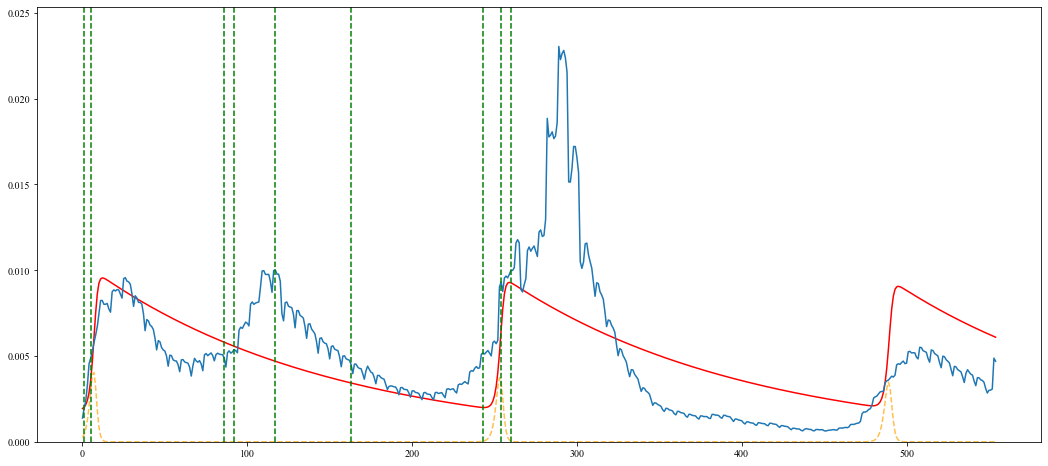

In [76]:
dates, I, R, D = loadCAData()
consts = [len(I), I[0], max(I), 0]

#californiaParams = getParams(I, consts, randomIterCount=50, method = "Nelder-Mead")


fig,ax = graphParams(californiaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(californiaParams)

measureDates = getCountryDates("California Closure Data", filePathOver="../../Data/California Test Data/")
print(measureDates)
for measure in measureDates:
    if(getIndex(dates,measure) != -1):
            plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')
            
            